In [1]:
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from astropy.modeling import models, fitting

import jungfrau_utils as ju
from alvra_tools import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


### Location of the BSREAD file with PSSS data and the file with corrected images

In [10]:
bsread_file = "/sf/alvra/data/p17982/raw/OCP_2a_LCP_300fs_1uJ/run_000362.BSREAD.h5"
images_file = "/sf/alvra/data/p17982/res/OCP_2a_LCP_300fs_1uJ/data/dark/run_000362.JF06T08V01.h5"

### Load the PSSS data from BSREAD file using alvra_tools

In [3]:
(Energy, FWHM, X, Y, pulseID) = \
load_PSSS_data_from_scans_pulseID(bsread_file,channel_PSSS_center, 50)

### Load the images and pulse_ids of images with hits using alvra_tools

In [5]:
channel_corr_JF_pulse_ids

'/data/pulse_id'

In [11]:
(Images, pulseID_img) = load_corr_JF_data(images_file)

### Filter out spectra that don't have corresponding JF images

In [12]:
X_filtered = []
Y_filtered = []
Energy_filtered = []

# find matching pulseID's
for i in range(0, len(pulseID_img)):
    for j in range(0, len(pulseID)):
        if pulseID_img[i] == pulseID[j]:
            
            X_filtered.append(X[j])
            Y_filtered.append(Y[j])
            en = float(Energy[j])
            Energy_filtered.append(en)
        

X_filtered = np.asarray(X_filtered)
Y_filtered = np.asarray(Y_filtered)
#Energy_filtered = np.asarray(Energy_filtered)

In [13]:
Energy_filtered

[11992.049705124604,
 11989.380148126706,
 11989.391918330202,
 11997.620845180933,
 11987.996677544217,
 11982.944371183345,
 11997.514517991624,
 12000.189658712414,
 12002.168278875552,
 11998.359607970775,
 11997.370233220041,
 11991.139578660057,
 11994.825484086661,
 11993.088107345393,
 11993.584676996043,
 11990.984107769757,
 11991.787775024492,
 11995.871497321827,
 11997.467116590004,
 11989.059305292969,
 11996.639203545046,
 12003.667847711331,
 11994.320077124867,
 11996.84930360174,
 11997.55156630106,
 11997.511020203709,
 11997.584802485426,
 11996.484417140802,
 11991.12005554994,
 11996.17831754947,
 11990.603017849742,
 12001.199564692432,
 11996.909542321995,
 11993.520703731472,
 11993.178552206542,
 11993.378374383667,
 11996.06225889807,
 11991.674308313959,
 11986.723172619624,
 11992.706658876376,
 11990.162256730686,
 11991.038966810183,
 11990.78341987545,
 11995.156651648133,
 11993.465409359209,
 11993.035334303746,
 11992.470036141032,
 11988.618279815591

In [14]:
Energy_filtered.shape

AttributeError: 'list' object has no attribute 'shape'

### Plot single spectra

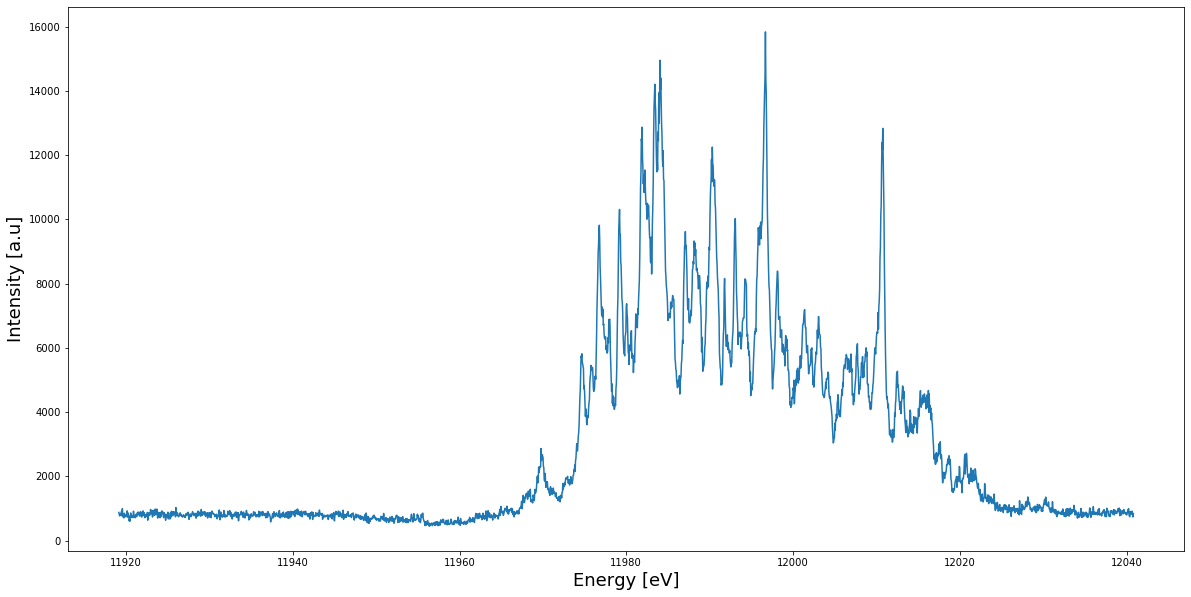

In [15]:
plt.figure(figsize=(20,10))
plt.plot(X[0], Y_filtered[0])
plt.xlabel('Energy [eV]', fontsize=18)
plt.ylabel('Intensity [a.u]', fontsize=18)
plt.show()

### Smooth spectra

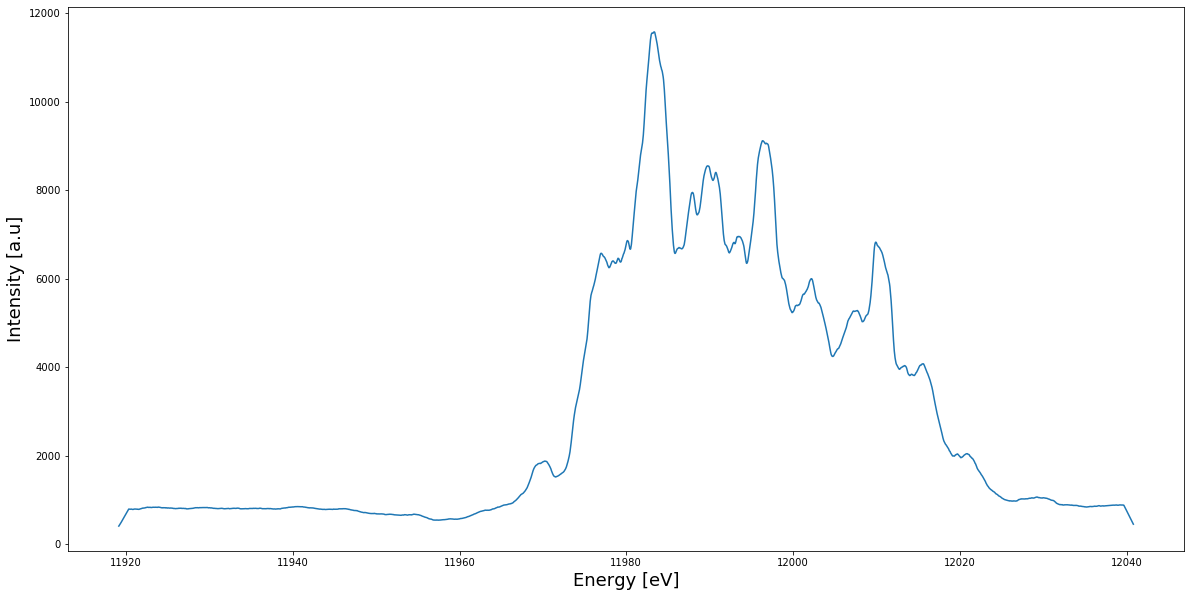

In [16]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(20,10))
plt.plot(X[0], smooth(Y_filtered[0],50))
plt.xlabel('Energy [eV]', fontsize=18)
plt.ylabel('Intensity [a.u]', fontsize=18)
plt.show()

### Fit the smoothed spectra with astopy

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev      
    ----------------- ------------------ ------------------
    8086.349571261712 11992.472816509124 16.196997376238773
[11991.80135491]
10103749692


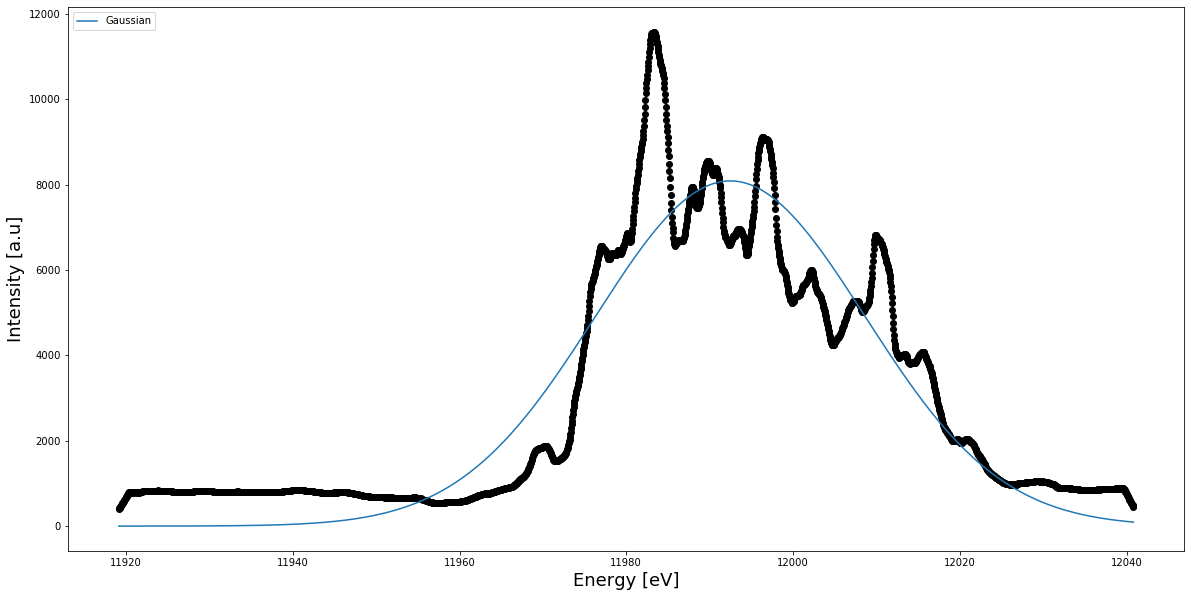

In [18]:
x = X[0]
y = smooth(Y_filtered[0],50)

#g_init = models.Gaussian1D(amplitude=10000., mean=11210, stddev=15.)
g_init = models.Gaussian1D(amplitude=40000., mean=12000, stddev=19.)

fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(20,10))
plt.plot(x, y, 'ko')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Energy [eV]', fontsize=18)
plt.ylabel('Intensity [a.u]', fontsize=18)
plt.legend(loc=2)
print(g)
print(Energy[8])
print(pulseID[8])

### Fit all single spectra 

In [21]:
g_init = models.Gaussian1D(amplitude=40000., mean=12000, stddev=19.)
fit_g = fitting.LevMarLSQFitter()

Energy_fit_mean = []
Energy_fit_amp = []
Energy_fit_std = []

for i in range(0,len(Y_filtered)):
    y = smooth(Y_filtered[i],50)
    g = fit_g(g_init, x, y)
    
    Energy_fit_mean.append(g.mean.value)
    Energy_fit_amp.append(g.amplitude.value)
    Energy_fit_std.append(g.stddev.value)

In [22]:
Energy_fit_mean

[11992.472816509124,
 11989.666489719053,
 11989.840009545862,
 11997.863403730033,
 11988.54021814005,
 11982.989827047593,
 11997.792834968788,
 12000.825139977296,
 12002.17654370886,
 11998.832259246505,
 11997.570804121362,
 11991.357551916899,
 11995.157815149852,
 11993.8758687432,
 11994.000560836146,
 11991.193965412214,
 11992.328447111182,
 11996.07819101155,
 11997.679853821463,
 11989.412171696586,
 11997.096336076582,
 12003.672663343912,
 11994.598887332646,
 11997.024329987638,
 11998.078998371087,
 11997.861511617602,
 11997.975210630946,
 11996.792692160177,
 11991.260176868585,
 11996.559979068033,
 11990.956903260456,
 12001.29091987532,
 11997.150251325904,
 11993.868452441538,
 11994.655908526309,
 11994.039353017335,
 11996.40419758729,
 11991.925361890502,
 11986.82140774609,
 11992.789579602575,
 11990.634906501542,
 11991.386382912244,
 11991.360361844563,
 11995.47139993496,
 11994.185795110558,
 11994.48196440918,
 11992.851654812936,
 11988.741430896554,
 1

### Reshape arrays (that was a bad idea...)

In [ ]:
#Energy_fit_mean = np.reshape(Energy_fit_mean, (-1,1))
#Energy_fit_amp = np.reshape(Energy_fit_amp, (-1,1))
#Energy_fit_std = np.reshape(Energy_fit_std, (-1,1))
#Energy_fit_mean.shape
#Energy_fit_mean

### Save the hdf5 file with images, pulseIDs, energy from PSSS and from the fit

In [42]:
save_file = '/das/work/p17/p17984/karol/PSSS/run_000096.energy.JF06T08V01.h5'
#save(save_file, data=Images, pulse_id=pulseID_img, energy_psss=Energy_filtered, energy_fit=Energy_fit_filtered)
save(save_file, data=Images, pulse_id=pulseID_img, energy_psss=Energy_filtered, energy_fit=Energy_fit_mean)

### Check what's in the saved file

In [ ]:
jf_file = h5py.File(save_file)
print(jf_file)
#channel_raw_JF_images = "/data/JF06T08V01/data"

en_psss = jf_file['energy_psss']
en_fit = jf_file['energy_fit']

print(en_psss[0:3])
print(en_fit[0:3])